# dp100_11 Azure MLを使用して機械学習モデルをトレーニングする

## トレーニングスクリプトを実行する

`ScriptRunConfig`を使用すると、機械学習モデルをトレーニングするスクリプトベースの実験を実行できる。

### モデルをトレーニングするためのスクリプトを作成する

実験を使用してモデルをトレーニングする場合、スクリプトによって**output**フォルダにトレーニング済みモデルが保存される。  
たとえば、次のスクリプトでは、scikit-learnを使用してモデルをトレーニングし、**joblib**パッケージを使用してそれを**output**フォルダに保存する。

```
from azureml.core import Run
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 実験の実行コンテキストの取得
run = Run.get_context()

# データセットの準備
diabetes = pd.read_csv('data.csv')
X, y = diabetes[['Feature1','Feature2','Feature3']].values, diabetes['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

# ロジスティック回帰モデルのトレーニング
reg = 0.1
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

# 精度計算
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
run.log('Accuracy', np.float(acc))

# トレーニング済みモデルの保存
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=model, filename='outputs/model.pkl')

run.complete()
```

モデルをトレーニングする実験を準備するために、このようなスクリプトを作成し、フォルダに保存する。  
たとえば、kのスクリプトを**training_folder**という名前のフォルダに**training_script.py**として保存できる。  
このスクリプトには**data.csv**からトレーニングデータを読み込むコードが含まれているため、このファイルもそのフォルダに保存する必要がある。

### スクリプトを実験として実行する

スクリプトを実行するには、フォルダおよびスクリプトファイルを参照する**ScriptRunConfig**を作成する。  
通常は、スクリプトに必要なパッケージをすべて含むPython(Conda)環境も定義する必要がある。  
この例では、スクリプトにscikit-learnが使用されているので、それを含む環境を作成する必要がある。  
またこのスクリプトには、メトリックをロギングするためにAzureMLが使用されているので、**azureml-defaults**パッケージを環境に含めることも忘れないこと。

```
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.conda_dependencies import CondaDependencies

# 実験用のPython環境を構築
sklearn_env = Environment("sklearn-env")

# 必要なパッケージがインストールされていることを確認
packages = CondaDependencies.create(conda_packages=['scikit-learn','pip'],
                                    pip_packages=['azureml-defaults'])
sklearn_env.python.conda_dependencies = packages

# スクリプトコンフィグの作成
script_config = ScriptRunConfig(source_directory='training_folder',
                                script='training.py',
                                environment=sklearn_env) 

# 実験の実行
experiment = Experiment(workspace=ws, name='training-experiment')
run = experiment.submit(config=script_config)
run.wait_for_completion()
```

## スクリプトパラメータの使用

スクリプトで変数を設定する引数を使用することで、スクリプトベースの実験の柔軟性を高めることができる。

### スクリプトの引数を操作する

スクリプトでパラメータを使用するには、`argparse`などのライブラリを使用してスクリプトに渡される引数を読み取り、それを変数に代入する必要がある。  
たとえば、次のスクリプトでは、`--reg-rate`という名前の引数を読み取る。  
これは、モデルのトレーニングに使用されるロジスティック回帰アルゴリズムの正則化項ハイパーパラメータを設定するために使用される。

```
from azureml.core import Run
import argparse
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 実験の実行コンテキストの取得
run = Run.get_context()

# 正規化のハイパーパラメータを取得
parser = argparse.ArgumentParser()
parser.add_argument('--reg-rate', type=float, dest='reg_rate', default=0.01)
args = parser.parse_args()
reg = args.reg_rate

# データセットの準備
diabetes = pd.read_csv('data.csv')
X, y = data[['Feature1','Feature2','Feature3']].values, data['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

# ロジスティック回帰モデルのトレーニング
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

# 精度計算
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
run.log('Accuracy', np.float(acc))

# トレーニング済みモデルの保存
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=model, filename='outputs/model.pkl')

run.complete()
```

### 実験スクリプトに引数を渡す

実験で実行されているスクリプトにパラメータ値を渡すには、以下のようにコンマ区切りの引数とその値のリストを含む**引数**値を**ScriptRunConfig**に指定する必要がある。

```
# スクリプトコンフィグの作成
script_config = ScriptRunConfig(source_directory='training_folder',
                                script='training.py',
                                arguments = ['--reg-rate', 0.1],
                                environment=sklearn_env)
```

## モデルの登録

モデルをトレーニングする実験を実行した後、**Run**オブジェクトへの参照を使用して、その出力をトレーニング済みモデルと共に取得できる。

### モデルファイルを取得する

実験の実行の完了後、Runオブジェクトの「**get_file_names**メソッドを使用して生成されたファイルを一覧表示できる。  
モデルをトレーニングするスクリプトの場合は、これをRunの**outputs**フォルダに保存する方法が標準的。

また、Runオブジェクトの**download_file**と**download_files**のメソッドを使用して、  
出力ファイルをローカルファイルシステムにダウンロードすることもできる。

```
# 'run'は完了した実験の実行を意味する

# 実験で生成されたファイルをリストアップ
for file in run.get_file_names():
    print(file)

# 名前付きファイルのダウンロード
run.download_file(name='outputs/model.pkl', output_file_path='model.pkl')
```

### モデルの登録

モデルの登録により、モデルの複数のバージョンを追跡し、推論(新しいデータからラベル地を予測)のモデルを取得できるようになる。  
モデルを登録するときに、名前、説明、タグ、フレームワーク(scikit-learnやpytorchなど)、フレームワークのバージョン、カスタムプロパティ、  
その他の便利なメタデータを指定できる。  
既存のモデルと同じ名前のモデルを登録すると、1から始まり、1ずつ増加する、そのモデルの新しいバージョンが自動的に作成される。

ローカルファイルからモデルを登録する場合は、ここに示すように、**Model**オブジェクトの**register**メソッドを使用できる。

```
from azureml.core import Model

model = Model.register(workspace=ws,
                       model_name='classification_model',
                       model_path='model.pkl', # local path
                       description='A classification model',
                       tags={'data-format': 'CSV'},
                       model_framework=Model.Framework.SCIKITLEARN,
                       model_framework_version='0.20.3')
```

また、モデルのトレーニングに使用された**Run**への参照がある場合は、ここに示すように**register_model**メソッドを使用できる。

```
run.register_model( model_name='classification_model',
                    model_path='outputs/model.pkl', # run outputs path
                    description='A classification model',
                    tags={'data-format': 'CSV'},
                    model_framework=Model.Framework.SCIKITLEARN,
                    model_framework_version='0.20.3')
```

### 登録済みモデルを表示する

AzureMLスタジオでは、登録済みモデルを表示できる。  
**Model**オブジェクトを使用して、次のような登録済みモデルの詳細を取得することもできる。

```
from azureml.core import Model

for model in Model.list(ws):
    # Get model name and auto-generated version
    print(model.name, 'version:', model.version)
```

## 演習 モデルのトレーニングと登録

AzureMLでは、スクリプトを使用して、scikit-learn、tensorflow、pytorch、sparkMLなどの、  
一般的な機械学習フレームワークを活用してモデルをトレーニングできる。  
これらの学習スクリプトを実験として実行することで、学習したモデルを含むメトリックやアウトプットを追跡することができる。

### ワークスペースへの接続

In [1]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.28.0 to work with 20210613


### トレーニングスクリプトの作成

Pythonスクリプトを使い、糖尿病データを元に機械学習モデルを学習することになるので、まずはスクリプトとデータファイルを置くフォルダを作成する。

In [2]:
import os, shutil

# Create a folder for the experiment files
training_folder = 'diabetes-training'
os.makedirs(training_folder, exist_ok=True)

# Copy the data file into the experiment folder
shutil.copy('data/diabetes.csv', os.path.join(training_folder, "diabetes.csv"))

'diabetes-training/diabetes.csv'

トレーニングスクリプトを作成する。

In [3]:
%%writefile $training_folder/diabetes_training.py
# Import libraries
from azureml.core import Run
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# 実験の実行コンテキストの作成
run = Run.get_context()

# 糖尿病データの読み込み
print("Loading Data...")
diabetes = pd.read_csv('diabetes.csv')

# 特徴量とラベルの分離
X, y = diabetes[['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']].values, diabetes['Diabetic'].values

# 訓練データとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# 正規化用ハイパーパラメータの設定
reg = 0.01

# ロジスティック回帰モデルの訓練
print('Training a logistic regression model with regularization rate of', reg)
run.log('Regularization Rate',  np.float(reg))
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

# 精度計算
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', np.float(acc))

# AUC計算
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))
run.log('AUC', np.float(auc))

# 出力フォルダへ訓練済みモデルを保存
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=model, filename='outputs/diabetes_model.pkl')

run.complete()

Overwriting diabetes-training/diabetes_training.py


### トレーニングスクリプトを実験として実行する

これで、スクリプトを実験として実行する準備が整った。  
デフォルトの環境にはscikit-learnパッケージは含まれていないため、コンフィグに明示的に追加する必要があることに注意すること。  
condaの環境は、実験の初回実行時にオンデマンドで構築され、次回以降の同じ構成での実行のためにキャッシュされるため、  
初回実行時には少し時間がかかる。

In [4]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails

# 実験のためのPython環境の構築
sklearn_env = Environment("sklearn-env")

In [5]:
# 必要なパッケージがインストールされていることを確認する
# ※pip, scikit-learn, azureml-defaultsが必要
packages = CondaDependencies.create(conda_packages=['pip', 'scikit-learn'],
                                    pip_packages=['azureml-defaults'])
sklearn_env.python.conda_dependencies = packages

In [6]:
# スクリプトコンフィグの作成
script_config = ScriptRunConfig(source_directory=training_folder,
                                script='diabetes_training.py',
                                environment=sklearn_env) 

In [7]:
# 実験の実行
experiment_name = 'mslearn-train-diabetes'
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.submit(config=script_config)

In [8]:
# ノートブックウィジェットで実行中の実験を表示
RunDetails(run).show()

# 実験が完了するまでブロック
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'mslearn-train-diabetes_1623633078_7f4631f6',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2021-06-14T01:12:45.627338Z',
 'endTimeUtc': '2021-06-14T01:12:56.579139Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '137bba82-bee9-487a-ad20-d97bfd47777e',
  'azureml.git.repository_uri': 'https://github.com/iguru0331/mslearn-dp100.git',
  'mlflow.source.git.repoURL': 'https://github.com/iguru0331/mslearn-dp100.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '9e7541ac0a3b8687508ec55f4450f2e08432e185',
  'mlflow.source.git.commit': '9e7541ac0a3b8687508ec55f4450f2e08432e185',
  'azureml.git.dirty': 'False'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_training.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataRef

**Run**オブジェクトよりメトリックや出力を取り出すことができる。

In [10]:
# ロギングされたメトリックやファイルを取得
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))
print('\n')
for file in run.get_file_names():
    print(file)

Regularization Rate 0.01
Accuracy 0.774
AUC 0.8484929598487486


azureml-logs/60_control_log.txt
azureml-logs/70_driver_log.txt
logs/azureml/10894_azureml.log
outputs/diabetes_model.pkl


### 学習済みモデルの登録

実験の出力には、学習済みのモデルファイル(dabetes_model.pkl)が含まれていることに注意すること。  
このモデルをAzureMLのワークスペースに登録することで、モデルのバージョンを追跡し、後で取り出すことが可能になる。

In [11]:
from azureml.core import Model

# モデルの登録
run.register_model(model_path='outputs/diabetes_model.pkl', model_name='diabetes_model',
                   tags={'Training context':'Script'},
                   properties={'AUC': run.get_metrics()['AUC'], 'Accuracy': run.get_metrics()['Accuracy']})

Model(workspace=Workspace.create(name='20210613', subscription_id='153404fd-72ab-4092-b50e-de490c5509fc', resource_group='20210613'), name=diabetes_model, id=diabetes_model:1, version=1, tags={'Training context': 'Script'}, properties={'AUC': '0.8484929598487486', 'Accuracy': '0.774'})

In [12]:
# 登録されたモデルをリストアップ
for model in Model.list(ws):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

diabetes_model version: 1
	 Training context : Script
	 AUC : 0.8484929598487486
	 Accuracy : 0.774




> 注:上記のコードは、モデルの追加情報を記すために、プロパティとタグを使用している。  
プロパティとタグの主な違いは、モデルが登録された後、プロパティは変更できないのに対し、登録されたモデルのタグは変更できること。

### パラメータ化されたトレーニングスクリプトの作成

スクリプトにパラメータを追加することで、同じトレーニング実験を異なる設定で繰り返すことができ、  
トレーニング実験の柔軟性を高めることができる。  
ここでは、ロジスティック回帰アルゴリズムがモデルを学習する際に使用する正規化率のパラメータを追加する。

まず、パラメータ化したスクリプトと学習データを格納するフォルダを作成する。

In [13]:
import os, shutil

# Create a folder for the experiment files
training_folder = 'diabetes-training-params'
os.makedirs(training_folder, exist_ok=True)

# Copy the data file into the experiment folder
shutil.copy('data/diabetes.csv', os.path.join(training_folder, "diabetes.csv"))

'diabetes-training-params/diabetes.csv'

正則化率ハイパーパラメータの引数をもつスクリプトを作成する。  
引数はpythonのargparse.ArgumentParserオブジェクトを使って読み込まれる。

In [14]:
%%writefile $training_folder/diabetes_training.py
# Import libraries
from azureml.core import Run
import pandas as pd
import numpy as np
import joblib
import os
import argparse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# 実験実行コンテキストの取得
run = Run.get_context()

# 正規化のハイパーパラメータを設定
parser = argparse.ArgumentParser()
parser.add_argument('--reg_rate', type=float, dest='reg', default=0.01)
args = parser.parse_args()
reg = args.reg

# データセットの読み込み
print("Loading Data...")
diabetes = pd.read_csv('diabetes.csv')

# 特徴量とラベルを分離
X, y = diabetes[['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']].values, diabetes['Diabetic'].values

# 訓練データとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# ロジスティック回帰モデルの学習
print('Training a logistic regression model with regularization rate of', reg)
run.log('Regularization Rate',  np.float(reg))
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

# 精度計算
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', np.float(acc))

# AUC計算
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))
run.log('AUC', np.float(auc))

os.makedirs('outputs', exist_ok=True)
joblib.dump(value=model, filename='outputs/diabetes_model.pkl')

run.complete()

Writing diabetes-training-params/diabetes_training.py


### 引数を指定してスクリプトを実行する

先ほどと同じように、作成した環境を利用してスクリプトを実験として実行するが、  
今回はスクリプトが期待する`--reg_rate`パラメータを引数として指定する必要がある。

In [16]:
# スクリプトコンフィグの作成
script_config = ScriptRunConfig(source_directory=training_folder,
                                script='diabetes_training.py',
                                arguments = ['--reg_rate', 0.1],
                                environment=sklearn_env) 

In [17]:
# 実験の実行
experiment_name = 'mslearn-train-diabetes'
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'mslearn-train-diabetes_1623635043_b74cff95',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2021-06-14T01:44:05.412036Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'eb7a59d0-00ee-4d83-800e-5e5f505c19aa',
  'azureml.git.repository_uri': 'https://github.com/iguru0331/mslearn-dp100.git',
  'mlflow.source.git.repoURL': 'https://github.com/iguru0331/mslearn-dp100.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '9e7541ac0a3b8687508ec55f4450f2e08432e185',
  'mlflow.source.git.commit': '9e7541ac0a3b8687508ec55f4450f2e08432e185',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_training.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--reg_rate', '0.1'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},

今回も、完了した実行よりメトリックと出力を得ることができる。

In [18]:
# ロギングされたメトリックを取得
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))
print('\n')
for file in run.get_file_names():
    print(file)

Regularization Rate 0.1
Accuracy 0.774
AUC 0.8483198169063138


azureml-logs/60_control_log.txt
azureml-logs/70_driver_log.txt
logs/azureml/11329_azureml.log
outputs/diabetes_model.pkl


### 新しいバージョンのモデルを登録

新しいモデルをトレーニングしたので、ワークスペースに新しいバージョンとして登録できる。

In [19]:
from azureml.core import Model

# モデルの登録
run.register_model(model_path='outputs/diabetes_model.pkl', model_name='diabetes_model',
                   tags={'Training context':'Parameterized script'},
                   properties={'AUC': run.get_metrics()['AUC'], 'Accuracy': run.get_metrics()['Accuracy']})

# 登録モデルをリストアップする
for model in Model.list(ws):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

diabetes_model version: 2
	 Training context : Parameterized script
	 AUC : 0.8483198169063138
	 Accuracy : 0.774


diabetes_model version: 1
	 Training context : Script
	 AUC : 0.8484929598487486
	 Accuracy : 0.774




また、ワークスペースに登録されているモデルは、AzureMLスタジオの**モデル**ページで見ることができる。

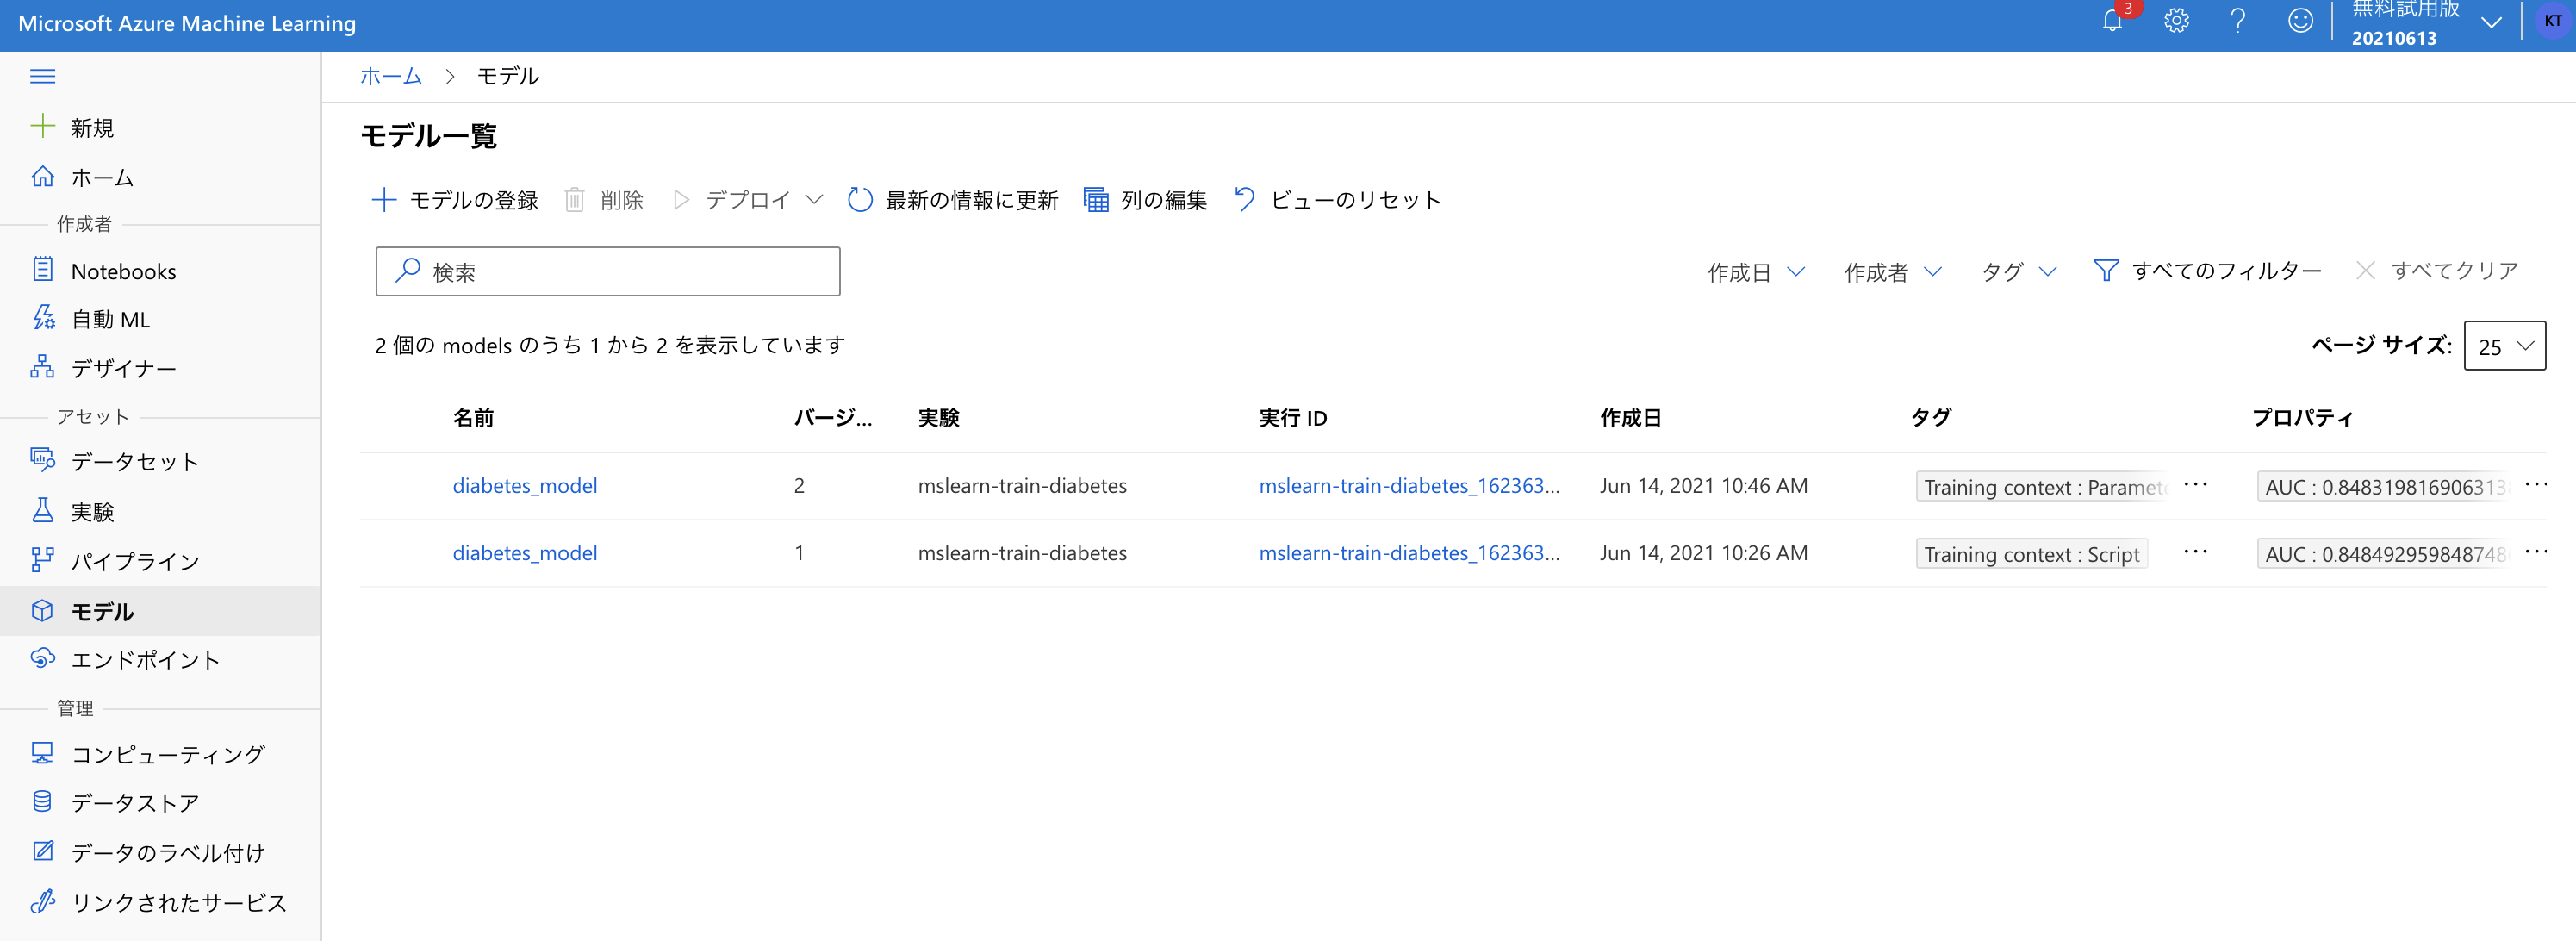

## 知識チェック

1. あなたは、実験が実行されるたびにバッチ サイズと学習率のハイパーパラメーターを指定された値に設定するスクリプトベースの実験を使用して、  
PyTorch モデルをトレーニングします。 何をする必要がありますか?
- 複数のスクリプト ファイルを作成します。使用するバッチ サイズと学習率との組み合わせごとに 1 つです。
- 実験を実行する前に、ScriptRunConfig の batch_size および learning_rate プロパティを設定します。
- バッチ サイズと学習率の引数をスクリプトに追加し、それらを ScriptRunConfig の arguments プロパティに設定します。

2. 実験を実行してモデルをトレーニングしました。 モデルをワークスペースに格納し、他の実験や公開済みのサービスで使用したいと考えています。  
何をする必要がありますか?

- ワークスペースでモデルを登録する。
- モデルをファイルとしてコンピューティング インスタンスに保存する。
- 実験スクリプトをノートブックとして保存する。

↓解答

1. バッチ サイズと学習率の引数をスクリプトに追加し、それらを ScriptRunConfig の arguments プロパティに設定します。
    - 毎回異なる値を使用するには、スクリプト内に引数を定義し、ScriptRunConfig の arguments パラメーターを使用してそれらを渡します。
2. ワークスペースでモデルを登録する。
    - ワークスペースにモデルを格納するには、モデルを登録します。